# Amazon fine food Review Analysis 
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consist of reviews of fine food from Amazon

Data include: 
1. Number of reviews: 568,454 
2. Number of users : 256,059 
3. Number of products : 74,258 
4. TimeSpan: Reviews from Oct 1999 - Oct 2012
5. Number of columns/features in data :10

Information of column or feature:
1. Id :Row Id
2. ProductId : Unique identifier for the product
3. UserId : Unqiue identifier for the user (256059=unique values)
4. ProfileName : Profile name of the user (218418=unique values)
5. HelpfulnessNumerator : Number of users who found the review helpful
6. HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not
7. Score : Rating between 1 and 5
8. Time: Timestamp for the review
9. Summary: Brief summary of the review (295744=unique values)
10. Text: Text of the review(393579 =unique values)

<b> Objective :</b>
1. Given a review, determine whether the review is positive (Rating 4or5) or neagative(2or3).
2. TSNE visualization of Amazon reviews with polarity based color-coding (that means predicting whether review is positive or not)

    
Q. How to determine if a review is postive or negative ?

Ans. We could use the Scoring/Rating . A Rating of 4 or 5 could be considered as positve and a Rating of 1 or 2 could be considered as negative.A rating of 3 can be considere as neutral and can be neglected. This is an approximation and proxy way of determining the porality(postive/negative) of review.





# Loading the DataSet
The data set is in two form 
1. .csv file 
2. SQLite Database

In order to load the dataset ,We have used the SQLITE Dataset as it easier to query the data and viualize the data efficiently.
Here as we only want to get the global sentiment of the recommendation(positive or negative), we will purposefully ignore all Score equal to 3 .If the score id above 3 ,then the recommendation will be 'positive'.Otherwise ,it will be sent to "neagtive".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score,auc
from nltk.stem.porter import PorterStemmer
    
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle 

from tqdm import tqdm
import os

# Reading Data

In [2]:
#using the SQlite Table to read data.
con=sqlite3.connect('database.sqlite')
#filtering only positive and negative reviews and not taking into consideration those review with score=3

filtered_data=pd.read_sql_query("""SELECT * FROM Reviews Where Score !=3""",con)
print(filtered_data.shape)

def partition(x): #defining the function for converting : 1or 2 to "0" and 4 or 5 to "1"
    if x<3:
        return 0
    return 1
# Changing the reviews with score less than 3 to be negative and greater than 3 to be postive
actual_score= filtered_data['Score'] #it will give only score attributes and store in actual_score
Postive_negative =actual_score.map(partition)
# it will use the partion func we have created and chang the score in 1 or 0and 
#save in variable "Positive_negative"
filtered_data['Score']=Postive_negative # it will replace the score column with 0 or 1 (from 1,2&3,4-0,1)
print('No of data point in our dataset ',filtered_data.shape)
filtered_data.head(3)

(525814, 10)
No of data point in our dataset  (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
# Counting the no. of time same user has given the review
display = pd.read_sql_query("""
SELECT UserId,ProductId ,ProfileName,Time,Score,Text,COUNT(*)
FROM Reviews
GROUP BY UserId 
HAVING COUNT(*)>1
""",con)

In [4]:
display.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
print('No. of rows and column in Display,' ,display.shape)

No. of rows and column in Display, (80668, 7)


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


# Exploratory Data Analysis 

### Data Cleaning :Deduplication
1. It is observed (as shown in the data below) the reviews has many duplicates entries .Hence it was neccessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [7]:
display=pd.read_sql_query("""
SELECT * FROM Reviews WHERE Score!=3 AND UserId="AR5J8UI46CURR" ORDER BY ProductId """,con)

In [8]:
display.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies,8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence inorder to reduce reduntancy it was decided to eleminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similiar product reviews and delete the others .This method ensures that there is only one representatives for each product and deduplication without sorting would lead to possibility of different reprsentatives still existing for the same product.


In [9]:
#sorting data accoring to ProductId  in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
##print(sorted_array.head())
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [10]:
final_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName" , "Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observsation:</b> It is also seen that in few rows given below the value of HelpfulnessNumerator > HelpfulnessDenominator which is practically impossible ,hence these rows are too removed from calculatio

In [12]:
display=pd.read_sql_query(""" SELECT * FROM 
Reviews WHERE Score!=3 AND Id=44737 OR Id=64422 ORDER BY ProductId""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final_data=final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [14]:
#Before starting the next phase of preprocessing lets see the no. of entries left
print(final_data.shape)

(364171, 10)


In [15]:
#HOw many positive and negative reviews are present in the dataset
final_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# Text Preprocessing : Stemming ,Stop-words Removal and Lemmatization
Till no we have finished data deduplication , now we will do preprocessing part before we go for futher analysis and making the prediction models.

Hence in Preprocessing part we will do the following things
1. Removing the HTML tags.
2. Removing any punctuation or some special character like # or , or .etc
3. Checking the word is made of english letter and is not alphanumeric.
4. Checking to see if the length of the words is greater than 2(as it was research that there is no adjective in 2 letters)
5. Convert all the words in lowercase
6. Removing the stopwords.
7. Using Snowball Stemming for the words(using Snowball Stemming as it is better than Porter Stemming)

In [16]:
# finding the HTML tags in sentences
i=0
for review in final_data['Text'].values:
    if(len(re.findall('<.*?>',review))):
        print(i)
        print(review)
        break
    i=i+1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [17]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop_words= set(stopwords.words('english')) #creating set of stopwords
#excluding few stop_words which are imp
excluding_stop= ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
print('*'*15)

stop_words=[words for words in stop_words if words not in excluding_stop] 
print('')
print(stop_words)

#intialising the snowballstem
snowstem=nltk.stem.SnowballStemmer('english')

print('')
print("***"*16)
print('Base words for tasty:',snowstem.stem('tasty')) # it will tell us the base word or do stemming

# creating the  function to clean the words containing HTML-tags. 
#The funtion will remove  the html-tags and everything between them with '1' space
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned= re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned= re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
    return cleaned

***************

['ll', 'yours', 'whom', 'his', 'will', 'they', 'itself', 'shan', 'at', 'such', 're', 'himself', 'my', 'all', 'before', 'between', 'she', 'we', 'have', 'can', 'as', 'own', 'ours', 'most', 'very', 'o', 'same', 'on', 'her', 'are', "shan't", 'your', 'yourself', 'or', "that'll", 'for', 'in', 'if', 'too', 'you', 'where', 'to', 'again', 'having', 'about', 'both', 'him', 'ourselves', 'until', 'an', 'with', 'further', 'up', 'was', 'them', 'each', 's', 'were', 'other', 'their', 'it', 'than', 'this', 'that', 'yourselves', 'only', 't', 'but', 'been', 'into', 'herself', 'being', 'did', "she's", 'then', 'theirs', 'of', 'hers', 'is', 'who', 'doing', 'once', 'during', "you're", 'because', 'here', 'me', 'below', 'over', 'does', "should've", 'few', 'no', 'its', 'what', 'the', 'y', 'these', 'do', "you've", 'any', 'down', 'our', 'out', 'now', 'i', "it's", 'by', 'from', 'those', 'nor', 'ma', 'and', 'while', 'myself', 'how', 'just', 've', 'there', 'above', "you'll", 'some', 'off', 'should',

In [18]:
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_review=[] # storing all the words from +ve review .
    all_negative_review=[] # storing all the words from -ve review.
    for i , review in enumerate(tqdm(final_data['Text'].values)):
        filter_sentences=[]
        review=cleanhtml(review) #remove the html tags and data within tags with "1" space
        for words in review.split(): 
            #Using cleanpunc(w).split(),, one more split function here example:w="abc.def" ,cleanpunc will return "abc def"
            #if we dont use .split() function then we will be considering "abc def" as a single word, 
            #but if we use .split() function we will get "abc",def
            for cleaned_words in cleanpunc(words).split(): #removing the punctuation or special character
                if((cleaned_words.isalpha())& (len(cleaned_words)>2)):
                    if (cleaned_words.lower() not in stop_words):
                        #using Snowball stemmer for e.g: tasty or tasteful="tasti"
                        s=(snowstem.stem(cleaned_words.lower())).encode('utf8')
                        filter_sentences.append(s)
                        if (final_data['Score'].values[i]==1):
                            all_positive_review.append(s)  #list of all words used to describe positive reviews
                        if (final_data['Score'].values[i]==0):
                            all_negative_review.append(s)   #list of all words used to describe negative reviews 
                    else:
                        continue
                else:
                    continue
        str1=b" ".join(filter_sentences) #final string of clean words
        #print("***********************************************************************")
        final_string.append(str1)
        i+=1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [15:09<00:00, 400.34it/s]


In [19]:
#adding column of Clean_text which display the data after pre-processing of the review.
final_data['Clean_text']=final_string
print(final_data['Clean_text'].values)
final_data['Clean_text']=final_data['Clean_text'].str.decode('utf-8')
final_data['Clean_text'].values

[b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'
 b'grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open'
 b'fun way children learn month year learn poem throughout school year like handmot invent poem'
 ...
 b'bought hazelnut past nocciola spread local shop palm cost florida tast excel healthier nutella'
 b'purchas product local store kid love quick easi meal put toaster oven toast min readi eat strong recommend'
 b'purchas send son whos away colleg deliv right dorm room fast ship love much call thank sad hard ever call anymor want kid call home good snack get midterm send']


array(['witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg',
       'grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open',
       'fun way children learn month year learn poem throughout school year like handmot invent poem',
       ...,
       'bought hazelnut past nocciola spread local shop palm cost florida tast excel healthier nutella',
       'purchas product local store kid love quick easi meal put toaster oven toast min readi eat strong recommend',
       'purchas send son whos away colleg deliv right dorm room fast ship love much call thank sad hard ever call anymor want kid call home good snack get midterm send'],
      dtype=object)

In [20]:
# Store the final table into an SQLITE table for future 
conn= sqlite3.connect('final1.sqlite')
c=conn.cursor()
conn.text_factory=str
final_data.to_sql('reviews',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)
conn.close()

In [21]:
final_data[['Text','Clean_text']]

,Text,Clean_text
138706,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,"I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...
...,...,...
178145,"LOVE, LOVE this sweetener!! I use it in all m...",love love sweeten use bake unsweeten flavor co...
173675,You have to try this sauce to believe it! It s...,tri sauc believ start littl sweet honey tast b...
204727,I bought this Hazelnut Paste (Nocciola Spread)...,bought hazelnut past nocciola spread local sho...
5259,Purchased this product at a local store in NY ...,purchas product local store kid love quick eas...


# t-SNE :Using Scikit-Learn
<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

# Applying TNSE on Text BOW vectors

# BOW [Bag of Words]: A Simple tecnique to convert words to vector

In [33]:
#Bow
#in sklearn: Convert a collection of text documents to a matrix of token counts
count_vec= CountVectorizer()
final_uni_count=count_vec.fit_transform(final_data['Clean_text'].values)

In [34]:
print('The type of count vectorizer:',type(final_uni_count))
print('Shape of BOW vectorizer:',final_uni_count.get_shape())
print('No. of Unique words:',final_uni_count.get_shape()[1])

The type of count vectorizer: <class 'scipy.sparse.csr.csr_matrix'>
Shape of BOW vectorizer: (364171, 120729)
No. of Unique words: 120729


## Standardising the data 

In [35]:
 
from sklearn.preprocessing import StandardScaler
std_data=StandardScaler(with_mean=False).fit_transform(final_uni_count)
std_data.shape

(364171, 120729)

# Performing t-sne over 2000 datapoints after standardising data

In [36]:
#picking the top 2000 points as TSNE take a lot of time for 364K
data_2000=std_data[0:2000,:].todense()
labels_2000=final_data['Score'][0:2000]

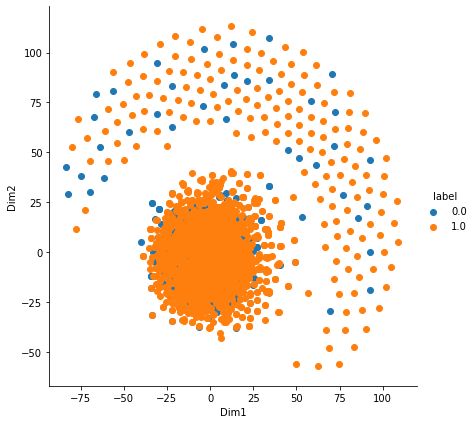

In [37]:
#t-sne
from sklearn.manifold import TSNE
import seaborn as sns

model=TSNE(n_components=2,random_state=0)
#configuring the parameters
#the number of components=2
#default perplexity=30
#default learingrate=200
#default Maximum no. of  iterationfor the optimization=1000
tsne_data=model.fit_transform(data_2000)

#creating a new data frame which help us in plotting the result data
tsne_data=np.vstack((tsne_data.T,labels_2000)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1',"Dim2",'label'))

#plotting the result of tsne
sns.FacetGrid(tsne_df,hue='label',size=6).map(plt.scatter,'Dim1',"Dim2").add_legend()
plt.show()

<b> Observation :</b>
1. We observed that in this t-sne plot  on taking 2K poins,both class label (postive and negative class)data points are not that much clearly seperable by which we cannot make model to classify both class datapoints.
2. And we also see that data poitns of both the classes between interval -25 to +25 are most of them overlapped
3. Between interval -100 to 60 on x-axis lots of orange points(postive class labels) are distributed in c-shaped and few blue points(negative claslabels are spread amoung orange points which make diffcult to seperate those points to make classification easier

# Changing the default parameter 

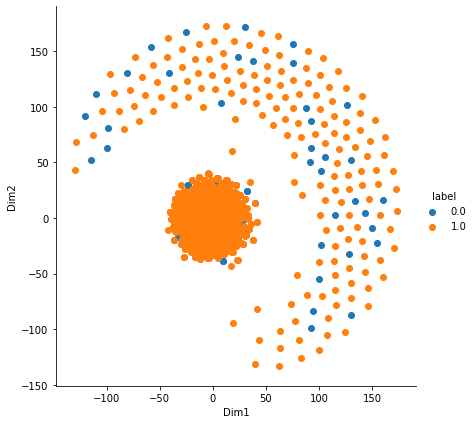

In [38]:
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#configuring the parameters
#the number of components=2
#default perplexity=10
#default learingrate=200
#default Maximum no. of  iterationfor the optimization=1000
tsne_data=model.fit_transform(data_2000)

#creating a new data frame which help us in plotting the result data
tsne_data=np.vstack((tsne_data.T,labels_2000)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1',"Dim2",'label'))

#plotting the result of tsne
sns.FacetGrid(tsne_df,hue='label',size=6).map(plt.scatter,'Dim1',"Dim2").add_legend()
plt.show()

<b> Observation :</b>
1. We observed that in this t-sne plot  on taking 2K poins,both class label (postive and negative class)data points are not that much clearly seperable by which we cannot make model to classify both class datapoints.
2. And we also see that data poitns of both the classes between interval -50 to +50 are most of them overlapped
3. Between interval -100 to 150 on x-axis lots of orange points(postive class labels) are distributed in c-shaped and few blue points(negative claslabels are spread amoung orange points which make diffcult to seperate those points to make classification easier

# Bi-gram and n-grams

In [30]:
#bi-gram,tri-gram,and n-gram
#removing stopwords like 'not' should be avoided before building n-grams
#ngram range  of(1,1(bydefaullt)) means only unigram (1,2)means unigram and bigram,(2,2)means only bigram
count_vect=CountVectorizer(ngram_range=(1,2))
final_bigram_count=count_vect.fit_transform(final_data['Text'].values)

In [31]:
print("The type of count_vetorizer:",type(final_bigram_count))
print('The shape of the text Bow vectorizer:',final_bigram_count.get_shape())
print('The number of Unique words including both unigrams and bigrams :',final_bigram_count.get_shape()[1])

The type of count_vetorizer: <class 'scipy.sparse.csr.csr_matrix'>
The shape of the text Bow vectorizer: (364171, 2910192)
The number of Unique words including both unigrams and bigrams : 2910192


# Standardising the data

In [76]:
from sklearn.preprocessing import StandardScaler
std_data=StandardScaler(with_mean=False).fit_transform(final_bigram_count)
std_data.shape

(364171, 2910192)

In [ ]:
#t-sne
from sklearn.manifold import TSNE
import seaborn as sns
#picking the top 2000 points as TSNE take a lot of time for 364K
data_2000=std_data[0:2000,:].todense()
labels_2000=final_data['Score'][0:2000]

In [ ]:
model=TSNE(n_components=2,random_state=0)
#configuring the parameters
#the number of components=2
#default perplexity=30
#default learingrate=200
#default Maximum no. of  iterationfor the optimization=1000
tsne_data=model.fit_transform(data_2000)

#creating a new data frame which help us in plotting the result data
tsne_data=np.vstack((tsne_data.T,labels_2000)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1',"Dim2",'label'))

#plotting the result of tsne
sns.FacetGrid(tsne_df,hue='label',size=6).map(plt.scatter,'Dim1',"Dim2").add_legend()
plt.show()

# Applying t-sne on Text tf-idf vectors

In [73]:
#tfidf
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_count=tf_idf_vect.fit_transform(final_data['Text'].values)

In [74]:
print("The type of tf_idf_vect:",type(final_tf_idf_count))
print('The shape of the text TF_IDF vectorizer:',final_tf_idf_count.get_shape())
print('The number of Unique words including both unigrams and bigrams:',final_tf_idf_count.get_shape()[1]) 

The type of tf_idf_vect: <class 'scipy.sparse.csr.csr_matrix'>
The shape of the text TF_IDF vectorizer: (364171, 2910192)
The number of Unique words including both unigrams and bigrams: 2910192


# Standardising the data

In [78]:
from sklearn.preprocessing import StandardScaler
std_data=StandardScaler(with_mean=False).fit_transform(final_tf_idf_count)
std_data.shape

(364171, 2910192)

In [79]:
from sklearn.manifold import TSNE
import seaborn as sns

#picking the top 2000 points as TSNE take a lot of time for 364K
data_2000=std_data[0:2000,:].todense()
labels_2000=final_data['Score'][0:2000]

MemoryError: Unable to allocate 43.4 GiB for an array with shape (2000, 2910192) and data type float64

In [ ]:
model=TSNE(n_components=2,random_state=0)
#configuring the parameters
#the number of components=2
#default perplexity=30
#default learingrate=200
#default Maximum no. of  iterationfor the optimization=1000
tsne_data=model.fit_transform(data_2000)

#creating a new data frame which help us in plotting the result data
tsne_data=np.vstack((tsne_data.T,labels_2000)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1',"Dim2",'label'))

#plotting the result of tsne
sns.FacetGrid(tsne_df,hue='label',size=6).map(plt.scatter,'Dim1',"Dim2").add_legend()
plt.show()